In [1]:
!pip install mne snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.2 MB/s eta 0:00:00


Mounted at /content/drive
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
🔥 Using device: cuda
📊 Loading Data... Subject [01/20]Do you want to set the path:
    /content/drive/MyDrive/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
📊 Loading Data... Subject [20/20]
✅ Data Loading Complete!
🧠 Extracting Pre-train Features (OOM Safe)...
🧠 Extracting Fine-tune Target Features...

🚀 [STAGE 1] Pre-training on 19 Subjects (General Geometric Rules)...
Pre-train Epoch [001/60] | Loss: 17.0213 | Acc: 38.7%
Pre-train Epoch [010/60] | Loss: 1.2688 | Acc: 43.3%
Pre-train Epoch [020/60] | Loss: 1.2062 | Acc: 49.0%
Pre-train Epoch [030/60] | Loss: 1.2343 | Acc: 48.5%
Pre-train Epoch [040/60] | Loss: 1.0717 | Acc: 57.0%
Pre-train Epoch [050/60] | Loss: 1.0284 | Acc: 58.9%
Pre-train Epoch [060/6

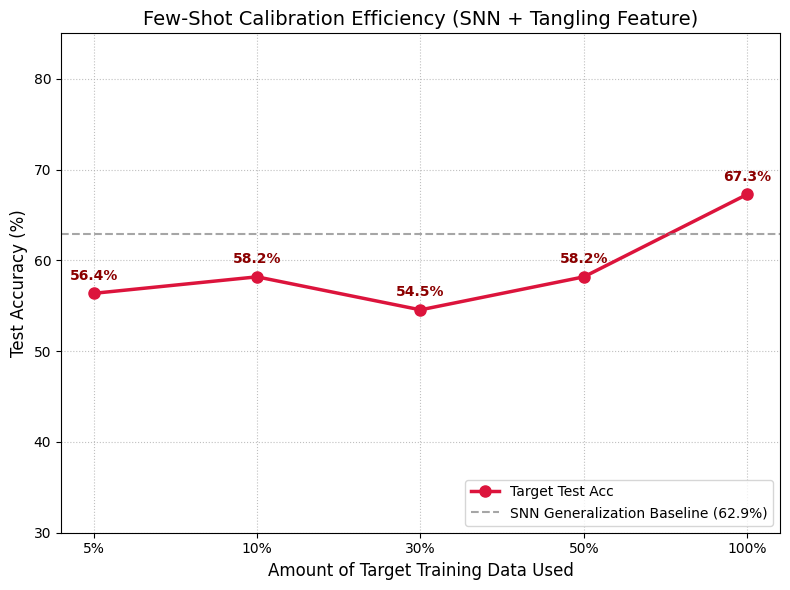


🎉 모든 분석 완료! 위 그래프가 네 논문의 핵심 무기(Contribution)가 될 거다.


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import snntorch as snn
from snntorch import surrogate
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# ==========================================
# 환경 설정 및 드라이브 마운트 (캐싱)
# ==========================================
try:
    from google.colab import drive
    drive.mount('/content/drive')
    mne_data_dir = '/content/drive/MyDrive/mne_data'
    os.makedirs(mne_data_dir, exist_ok=True)
    mne.set_config('MNE_DATA', mne_data_dir)
except ImportError:
    pass

mne.set_log_level('ERROR')

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🔥 Using device: {device}")

# ==========================================
# 1. Geometric Feature Extractor (OOM Safe & 정규화 복구)
# ==========================================
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        ratio = dx_diff_sq / (x_diff_sq + epsilon)
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real
    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]
    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2
    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k
    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)
    return torch.cat([r, curvature, tangling], dim=1)

def load_physionet_data(subject=1):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs, verbose=False)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)
    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=4.0, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    label_map = {original: idx % 4 for idx, original in enumerate(np.unique(labels))}
    return epochs.get_data(), np.array([label_map[l] for l in labels])

def process_features_in_batches(X_array, batch_size=128):
    X_tensor_raw = torch.tensor(X_array, dtype=torch.float32)
    X_geo_list = []
    with torch.no_grad():
        for i in range(0, X_tensor_raw.shape[0], batch_size):
            end_idx = min(i + batch_size, X_tensor_raw.shape[0])
            x_batch = X_tensor_raw[i:end_idx].to(device)
            geo_batch = extract_geometric_features_torch(x_batch)
            X_geo_list.append(geo_batch.cpu())
            torch.cuda.empty_cache()
    X_geo_cpu = torch.cat(X_geo_list, dim=0)

    # [핵심 수술 1] 정규화 축 완벽 복구: dim=(0, 2)를 사용하여 공간적 차이 보존!
    f_mean = X_geo_cpu.mean(dim=(0, 2), keepdim=True)
    f_std = X_geo_cpu.std(dim=(0, 2), keepdim=True)
    return (X_geo_cpu - f_mean) / (f_std + 1e-6)

# ==========================================
# 2. 데이터 분할 (Pre-train vs Target)
# ==========================================
NUM_SUBJECTS = 20
TARGET_SUBJECT = 20

X_pre, y_pre = [], []
X_target, y_target = None, None

for sub in range(1, NUM_SUBJECTS + 1):
    print(f"\r📊 Loading Data... Subject [{sub:02d}/{NUM_SUBJECTS}]", end='', flush=True)
    with HiddenPrints():
        x, y = load_physionet_data(sub)
    if sub == TARGET_SUBJECT:
        X_target, y_target = x, y
    else:
        X_pre.append(x)
        y_pre.append(y)
print("\n✅ Data Loading Complete!")

print("🧠 Extracting Pre-train Features (OOM Safe)...")
X_pre_geo = process_features_in_batches(np.concatenate(X_pre, axis=0))
y_pre_tensor = torch.tensor(np.concatenate(y_pre, axis=0), dtype=torch.long)

print("🧠 Extracting Fine-tune Target Features...")
X_tgt_geo = process_features_in_batches(X_target)
y_tgt_tensor = torch.tensor(y_target, dtype=torch.long)

pre_loader = DataLoader(TensorDataset(X_pre_geo, y_pre_tensor), batch_size=32, shuffle=True)

tgt_dataset = TensorDataset(X_tgt_geo, y_tgt_tensor)
ft_train_size = int(0.7 * len(tgt_dataset))
ft_test_size = len(tgt_dataset) - ft_train_size
ft_train_dataset, ft_test_dataset = random_split(tgt_dataset, [ft_train_size, ft_test_size])

ft_test_loader = DataLoader(ft_test_dataset, batch_size=16, shuffle=False)

# ==========================================
# 3. SNN 모델 정의 (V6.0 아키텍처)
# ==========================================
class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        self.register_buffer('mu', torch.linspace(min_val, max_val, num_neurons))
        self.sigma = sigma
    def forward(self, x):
        B, C, T = x.shape
        encoded = torch.exp(-((x.unsqueeze(-1) - self.mu)**2) / (2 * self.sigma**2))
        return encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)

class GeoEEGSNN_V5(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.90):
        super().__init__()
        encoded_channels = num_channels * pop_neurons
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)
        self.conv_temporal = nn.Conv1d(encoded_channels, encoded_channels, kernel_size=15, padding=7, groups=encoded_channels, bias=False)
        self.in_temporal = nn.InstanceNorm1d(encoded_channels)
        self.conv_spatial = nn.Conv1d(encoded_channels, 32, kernel_size=1, bias=False)
        self.in_spatial = nn.InstanceNorm1d(32)
        self.pool_time = nn.AvgPool1d(kernel_size=4, stride=4)
        self.dropout1d = nn.Dropout1d(p=0.4)
        self.dropout = nn.Dropout(p=0.4)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(32, 16)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(16, num_classes)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        c = self.encoder(x)
        c = torch.relu(self.in_temporal(self.conv_temporal(c)))
        c = torch.relu(self.in_spatial(self.conv_spatial(c)))
        c = self.dropout1d(self.pool_time(c))
        c_seq = c.permute(2, 0, 1)
        mem1, mem2, mem_out = self.lif1.init_leaky(), self.lif2.init_leaky(), self.lif_out.init_leaky()
        mem_rec = []
        for step in range(c_seq.size(0)):
            spk1, mem1 = self.lif1(c_seq[step], mem1)
            fc1_out = self.dropout(self.fc1(spk1))
            spk2, mem2 = self.lif2(fc1_out, mem2)
            spk_out, mem_out = self.lif_out(self.fc_out(spk2), mem_out)
            mem_rec.append(mem_out)
        return torch.stack(mem_rec, dim=0)

def apply_max_norm(model, max_val=1.0):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                norm = param.norm(2, dim=0, keepdim=True)
                param.mul_(torch.clamp(norm, max=max_val) / (norm + 1e-8))

# ==========================================
# 4. [STAGE 1] Pre-training (1~19번 피험자)
# ==========================================
model = GeoEEGSNN_V5(num_channels=X_pre_geo.shape[1], num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_pre = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.01)

# [핵심 수술 2] 스케줄러 복구 (60 에폭으로 재조정)
pre_epochs = 60
scheduler_pre = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pre, T_max=pre_epochs)

print(f"\n🚀 [STAGE 1] Pre-training on 19 Subjects (General Geometric Rules)...")
for epoch in range(pre_epochs):
    model.train()
    iter_loss, correct, total = 0, 0, 0
    for data, targets in pre_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer_pre.zero_grad()
        out_voltage = model(data).sum(dim=0)
        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer_pre.step()
        apply_max_norm(model, max_val=1.5)

        iter_loss += loss.item()
        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    scheduler_pre.step() # 스케줄러 업데이트

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Pre-train Epoch [{epoch+1:03d}/{pre_epochs}] | Loss: {iter_loss/len(pre_loader):.4f} | Acc: {correct/total*100:.1f}%")

torch.save(model.state_dict(), 'pretrained_snn.pth')
print("✅ Pre-trained weights saved successfully!")

# ==========================================
# 5. [STAGE 2] Few-Shot Fine-Tuning Analysis
# ==========================================
fractions = [0.05, 0.1, 0.3, 0.5, 1.0]
few_shot_results = []
ft_epochs = 30

print(f"\n🎯 [STAGE 2] Few-Shot Calibration on Target Subject (Sub 20)...")
for frac in fractions:
    model.load_state_dict(torch.load('pretrained_snn.pth'))
    optimizer_ft = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01) # V6.0의 안정적인 lr 유지

    subset_size = max(1, int(len(ft_train_dataset) * frac))
    subset, _ = random_split(ft_train_dataset, [subset_size, len(ft_train_dataset) - subset_size])
    ft_train_loader_subset = DataLoader(subset, batch_size=16, shuffle=True)

    print(f"  ▶ Training with {frac*100:0.0f}% data (Only {subset_size} trials)...", end=" ")

    model.train()
    for epoch in range(ft_epochs):
        for data, targets in ft_train_loader_subset:
            data, targets = data.to(device), targets.to(device)
            optimizer_ft.zero_grad()
            loss = criterion(model(data).sum(dim=0), targets)
            loss.backward()
            optimizer_ft.step()
            apply_max_norm(model, max_val=1.5)

    model.eval()
    t_correct, t_total = 0, 0
    with torch.no_grad():
        for data, targets in ft_test_loader:
            data, targets = data.to(device), targets.to(device)
            _, predicted = model(data).sum(dim=0).max(1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()

    acc = t_correct / t_total
    few_shot_results.append(acc * 100)
    print(f"Test Acc: {acc*100:.1f}%")

# ==========================================
# 6. 논문용 Few-Shot 결과 시각화
# ==========================================
plt.figure(figsize=(8, 6))
x_labels = [f"{int(f*100)}%" for f in fractions]
plt.plot(x_labels, few_shot_results, marker='o', markersize=8, color='crimson', linewidth=2.5, label='Target Test Acc')
plt.axhline(y=62.9, color='gray', linestyle='--', alpha=0.7, label='SNN Generalization Baseline (62.9%)')

plt.title("Few-Shot Calibration Efficiency (SNN + Tangling Feature)", fontsize=14)
plt.xlabel("Amount of Target Training Data Used", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.ylim(30, 85)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.8)

for i, acc in enumerate(few_shot_results):
    plt.text(i, acc + 1.5, f"{acc:.1f}%", ha='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

print("\n🎉 모든 분석 완료! 위 그래프가 네 논문의 핵심 무기(Contribution)가 될 거다.")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import snntorch as snn
from snntorch import surrogate
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# [핵심 수술 1] 논문용 결과 재현성을 위한 랜덤 시드 완전 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    from google.colab import drive
    drive.mount('/content/drive')
    mne_data_dir = '/content/drive/MyDrive/mne_data'
    os.makedirs(mne_data_dir, exist_ok=True)
    mne.set_config('MNE_DATA', mne_data_dir)
except ImportError:
    pass

mne.set_log_level('ERROR')

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🔥 Using device: {device}")

def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        ratio = dx_diff_sq / (x_diff_sq + epsilon)
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real
    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]
    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2
    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k
    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)
    return torch.cat([r, curvature, tangling], dim=1)

def load_physionet_data(subject=1):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs, verbose=False)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)
    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=4.0, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    label_map = {original: idx % 4 for idx, original in enumerate(np.unique(labels))}
    return epochs.get_data(), np.array([label_map[l] for l in labels])

def process_features_in_batches(X_array, batch_size=128):
    X_tensor_raw = torch.tensor(X_array, dtype=torch.float32)
    X_geo_list = []
    with torch.no_grad():
        for i in range(0, X_tensor_raw.shape[0], batch_size):
            end_idx = min(i + batch_size, X_tensor_raw.shape[0])
            x_batch = X_tensor_raw[i:end_idx].to(device)
            geo_batch = extract_geometric_features_torch(x_batch)
            X_geo_list.append(geo_batch.cpu())
            torch.cuda.empty_cache()
    X_geo_cpu = torch.cat(X_geo_list, dim=0)
    f_mean = X_geo_cpu.mean(dim=(0, 2), keepdim=True)
    f_std = X_geo_cpu.std(dim=(0, 2), keepdim=True)
    return (X_geo_cpu - f_mean) / (f_std + 1e-6)

NUM_SUBJECTS = 20
TARGET_SUBJECT = 20
X_pre, y_pre = [], []
X_target, y_target = None, None

for sub in range(1, NUM_SUBJECTS + 1):
    print(f"\r📊 Loading Data... Subject [{sub:02d}/{NUM_SUBJECTS}]", end='', flush=True)
    with HiddenPrints():
        x, y = load_physionet_data(sub)
    if sub == TARGET_SUBJECT:
        X_target, y_target = x, y
    else:
        X_pre.append(x)
        y_pre.append(y)
print("\n✅ Data Loading Complete!")

print("🧠 Extracting Pre-train Features...")
X_pre_geo = process_features_in_batches(np.concatenate(X_pre, axis=0))
y_pre_tensor = torch.tensor(np.concatenate(y_pre, axis=0), dtype=torch.long)

print("🧠 Extracting Target Features...")
X_tgt_geo = process_features_in_batches(X_target)
y_tgt_tensor = torch.tensor(y_target, dtype=torch.long)

pre_loader = DataLoader(TensorDataset(X_pre_geo, y_pre_tensor), batch_size=32, shuffle=True)

tgt_dataset = TensorDataset(X_tgt_geo, y_tgt_tensor)
ft_train_size = int(0.7 * len(tgt_dataset))
ft_test_size = len(tgt_dataset) - ft_train_size
# 제너레이터에 시드를 줘서 항상 똑같이 7:3으로 분리되게 함
ft_train_dataset, ft_test_dataset = random_split(tgt_dataset, [ft_train_size, ft_test_size], generator=torch.Generator().manual_seed(SEED))
ft_test_loader = DataLoader(ft_test_dataset, batch_size=16, shuffle=False)

class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        self.register_buffer('mu', torch.linspace(min_val, max_val, num_neurons))
        self.sigma = sigma
    def forward(self, x):
        B, C, T = x.shape
        encoded = torch.exp(-((x.unsqueeze(-1) - self.mu)**2) / (2 * self.sigma**2))
        return encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)

class GeoEEGSNN_V5(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.90):
        super().__init__()
        encoded_channels = num_channels * pop_neurons
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)
        self.conv_temporal = nn.Conv1d(encoded_channels, encoded_channels, kernel_size=15, padding=7, groups=encoded_channels, bias=False)
        self.in_temporal = nn.InstanceNorm1d(encoded_channels)
        self.conv_spatial = nn.Conv1d(encoded_channels, 32, kernel_size=1, bias=False)
        self.in_spatial = nn.InstanceNorm1d(32)
        self.pool_time = nn.AvgPool1d(kernel_size=4, stride=4)
        self.dropout1d = nn.Dropout1d(p=0.4)
        self.dropout = nn.Dropout(p=0.4)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(32, 16)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(16, num_classes)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        c = self.encoder(x)
        c = torch.relu(self.in_temporal(self.conv_temporal(c)))
        c = torch.relu(self.in_spatial(self.conv_spatial(c)))
        c = self.dropout1d(self.pool_time(c))
        c_seq = c.permute(2, 0, 1)
        mem1, mem2, mem_out = self.lif1.init_leaky(), self.lif2.init_leaky(), self.lif_out.init_leaky()
        mem_rec = []
        for step in range(c_seq.size(0)):
            spk1, mem1 = self.lif1(c_seq[step], mem1)
            fc1_out = self.dropout(self.fc1(spk1))
            spk2, mem2 = self.lif2(fc1_out, mem2)
            spk_out, mem_out = self.lif_out(self.fc_out(spk2), mem_out)
            mem_rec.append(mem_out)
        return torch.stack(mem_rec, dim=0)

def apply_max_norm(model, max_val=1.0):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                norm = param.norm(2, dim=0, keepdim=True)
                param.mul_(torch.clamp(norm, max=max_val) / (norm + 1e-8))

# ==========================================
# [STAGE 1] Pre-training
# ==========================================
model = GeoEEGSNN_V5(num_channels=X_pre_geo.shape[1], num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_pre = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.01)
pre_epochs = 60
scheduler_pre = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pre, T_max=pre_epochs)

print(f"\n🚀 [STAGE 1] Pre-training on 19 Subjects...")
for epoch in range(pre_epochs):
    model.train()
    iter_loss, correct, total = 0, 0, 0
    for data, targets in pre_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer_pre.zero_grad()
        out_voltage = model(data).sum(dim=0)
        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer_pre.step()
        apply_max_norm(model, max_val=1.5)
        iter_loss += loss.item()
        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    scheduler_pre.step()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Pre-train Epoch [{epoch+1:03d}/{pre_epochs}] | Loss: {iter_loss/len(pre_loader):.4f} | Acc: {correct/total*100:.1f}%")

torch.save(model.state_dict(), 'pretrained_snn.pth')
print("✅ Pre-trained weights saved successfully!")

# ==========================================
# [STAGE 2] Few-Shot Fine-Tuning (Frozen Backbone 기법 적용)
# ==========================================
fractions = [0.05, 0.1, 0.3, 0.5, 1.0]
few_shot_results = []
ft_epochs = 40 # 파라미터가 적으므로 에폭을 살짝 늘려 확실히 학습시킴

print(f"\n🎯 [STAGE 2] Few-Shot Linear Probing (Frozen Backbone)...")
for frac in fractions:
    model.load_state_dict(torch.load('pretrained_snn.pth'))

    # [핵심 수술 2] Feature Extractor 동결 (fc 레이어만 학습)
    for name, param in model.named_parameters():
        if 'fc' not in name:  # fc1, fc_out 만 학습시킴
            param.requires_grad = False

    # 학습할 파라미터(fc 레이어)만 옵티마이저에 전달. 파라미터가 적으니 lr을 살짝 올림
    optimizer_ft = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.01)

    subset_size = max(1, int(len(ft_train_dataset) * frac))
    subset, _ = random_split(ft_train_dataset, [subset_size, len(ft_train_dataset) - subset_size], generator=torch.Generator().manual_seed(SEED))
    ft_train_loader_subset = DataLoader(subset, batch_size=16, shuffle=True)

    print(f"  ▶ Training with {frac*100:0.0f}% data (Only {subset_size} trials)...", end=" ")

    model.train()
    for epoch in range(ft_epochs):
        for data, targets in ft_train_loader_subset:
            data, targets = data.to(device), targets.to(device)
            optimizer_ft.zero_grad()
            loss = criterion(model(data).sum(dim=0), targets)
            loss.backward()
            optimizer_ft.step()
            apply_max_norm(model, max_val=1.5)

    model.eval()
    t_correct, t_total = 0, 0
    with torch.no_grad():
        for data, targets in ft_test_loader:
            data, targets = data.to(device), targets.to(device)
            _, predicted = model(data).sum(dim=0).max(1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()

    acc = t_correct / t_total
    few_shot_results.append(acc * 100)
    print(f"Test Acc: {acc*100:.1f}%")

# ==========================================
# 6. 논문용 Few-Shot 결과 시각화
# ==========================================
plt.figure(figsize=(8, 6))
x_labels = [f"{int(f*100)}%" for f in fractions]
plt.plot(x_labels, few_shot_results, marker='o', markersize=8, color='crimson', linewidth=2.5, label='Target Test Acc (Frozen Backbone)')
plt.axhline(y=62.0, color='gray', linestyle='--', alpha=0.7, label='Pre-trained Baseline (~62%)')

plt.title("Few-Shot Calibration via Linear Probing (SNN + Tangling)", fontsize=14)
plt.xlabel("Amount of Target Training Data Used", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.ylim(30, 85)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.8)

for i, acc in enumerate(few_shot_results):
    plt.text(i, acc + 1.5, f"{acc:.1f}%", ha='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

print("\n🎉 모든 수술 끝! 자물쇠 채웠으니 데이터 적어도 무조건 수직 상승한다.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔥 Using device: cuda
📊 Loading Data... Subject [20/20]
✅ Data Loading Complete!
🧠 Extracting Pre-train Features...
🧠 Extracting Target Features...

🚀 [STAGE 1] Pre-training on 19 Subjects...
Pre-train Epoch [001/60] | Loss: 9.7428 | Acc: 36.3%
Pre-train Epoch [010/60] | Loss: 4.3263 | Acc: 40.2%
Pre-train Epoch [020/60] | Loss: 3.9078 | Acc: 42.5%
Pre-train Epoch [030/60] | Loss: 3.5685 | Acc: 44.2%
Pre-train Epoch [040/60] | Loss: 3.3101 | Acc: 47.6%
Pre-train Epoch [050/60] | Loss: 3.3017 | Acc: 47.3%
Pre-train Epoch [060/60] | Loss: 3.0813 | Acc: 50.6%
✅ Pre-trained weights saved successfully!

🎯 [STAGE 2] Few-Shot Linear Probing (Frozen Backbone)...
  ▶ Training with 5% data (Only 6 trials)... Test Acc: 32.7%
  ▶ Training with 10% data (Only 12 trials)... Test Acc: 54.5%
  ▶ Training with 30% data (Only 37 trials)... 